In [57]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = "image_data"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

training_datagen = ImageDataGenerator(
      rescale = 1./255,
      #rotation_range=180,
      #width_shift_range=0.3,
      #height_shift_range=0.2,
      #shear_range=0.4,
      #zoom_range=0.6,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (200, 200))

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_directory(val_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (200, 200))

Found 926 images belonging to 4 classes.
Found 28 images belonging to 4 classes.


In [58]:
train_generator.class_indices
train_generator.samples

926

Get a batch and try to see the output from the datagen

In [59]:
%matplotlib inline

import matplotlib.pyplot as plt

#check_images, y = next(train_generator)

#print(check_images[0].shape)

#for i, image in enumerate(check_images):
##    plt.imshow(image)
#    plt.text(0, 0, y[i])
#    plt.show()

In [60]:
# We're trying out fine-tuning Inception.
#
# start by loading the model with imagenet weights

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model

## SKIPPING INCEPTION TO GET SOMETHING BASIC CONVERGING FIRST!
#conv_base = InceptionV3(
#    weights="imagenet",
#    include_top=False,
#    input_shape=(200, 200, 3) # this is the size in our datagen
#)

# Freeze the base model
# conv_base.trainable = False

# Create the trainable top layers
inputs = layers.Input(shape=(200, 200, 3))

# rescale for inception defaults
#scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
#x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
#x = conv_base(x, training=False)

# try adding our own conv block
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.MaxPool2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.MaxPool2D(pool_size=2)(x)

# Finally add our inference layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary(show_trainable=True)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_28 (InputLayer) │ (None, 200, 200, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_21 (Rescaling)    │ (None, 200, 200, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1159 (Conv2D)        │ (None, 198, 198, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_75            │ (None, 99, 99, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1160 (Conv2D)        │ (None, 97, 97, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_76            │ (None, 48, 48, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_13 (Flatten)        │ (None, 147456)        │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_20 (Dense)            │ (None, 64)            │  9,437,248 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_21 (Dense)            │ (None, 4)             │        260 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 9,456,900 (36.08 MB)

 Trainable params: 9,456,900 (36.08 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
from tensorflow import keras
optimizer = keras.optimizers.Adam(learning_rate=0.1)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(
    train_generator, epochs=50,
    validation_data = val_generator
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - accuracy: 0.2366 - loss: 1.3941 - val_accuracy: 0.2500 - val_loss: 1.4007
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.2759 - loss: 1.3986 - val_accuracy: 0.2500 - val_loss: 1.3908
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - accuracy: 0.2696 - loss: 1.3883 - val_accuracy: 0.2500 - val_loss: 1.4014
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.2327 - loss: 1.4035 - val_accuracy: 0.2500 - val_loss: 1.3915
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.2360 - loss: 1.3941 - val_accuracy: 0.2500 - val_loss: 1.3926
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - accuracy: 0.2398 - loss: 1.3929 - val_accuracy: 0.2500 - val_loss: 1.3875
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - accuracy: 0.2509 - loss: 1.3924 - val_accuracy: 0.2500 - val_loss: 1.3880
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 449ms/step - accuracy: 0.2435 - loss: 1.3925 - val_accu

2024-06-02 00:25:41.263342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:521: Filling up shuffle buffer (this may take a while): 5 of 8


 1/47 ━━━━━━━━━━━━━━━━━━━━ 11:45:52 921s/step - accuracy: 0.3000 - loss: 1.3573

2024-06-02 00:25:42.797729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


29/47 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - accuracy: 0.2527 - loss: 1.4031

KeyboardInterrupt: 

Text(0.5, 1.0, 'Training and validation loss')

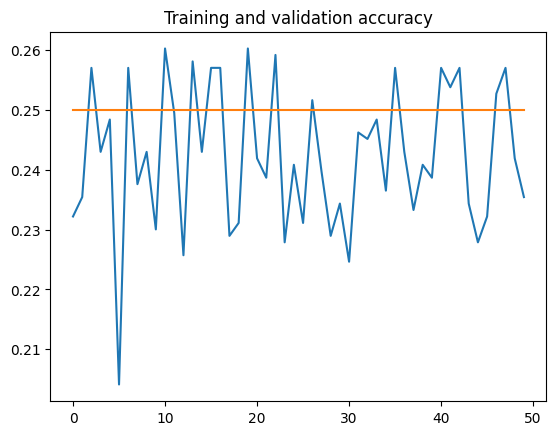

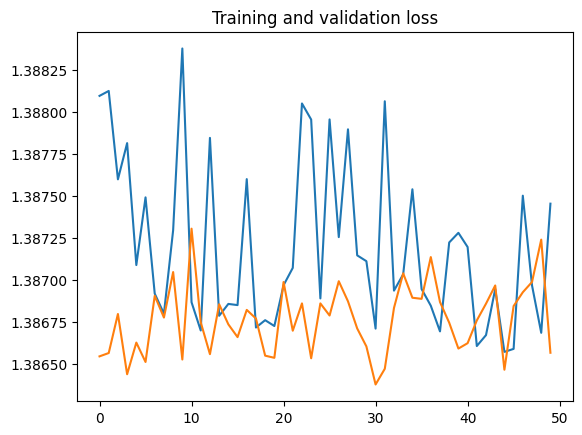

In [65]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )